## Automated Detection of Layers from Pictures

This cell loads one image at a time.

Non-Stacked


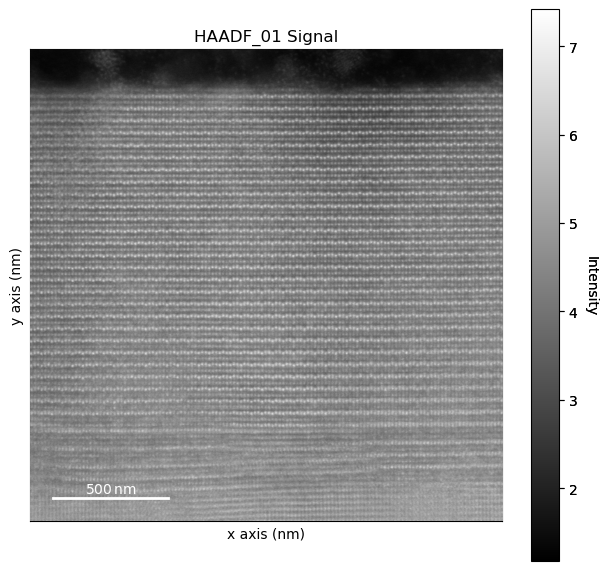

In [1]:
import skimage
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
sys.path.append('..')
import util.crop

stack_num = 0 # The index of stacked image

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time.
# These commented files are some that I want think could be reevaluated later for references.
s_load = hs.load('../data/images/Jaume LFO/HAADF_01.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

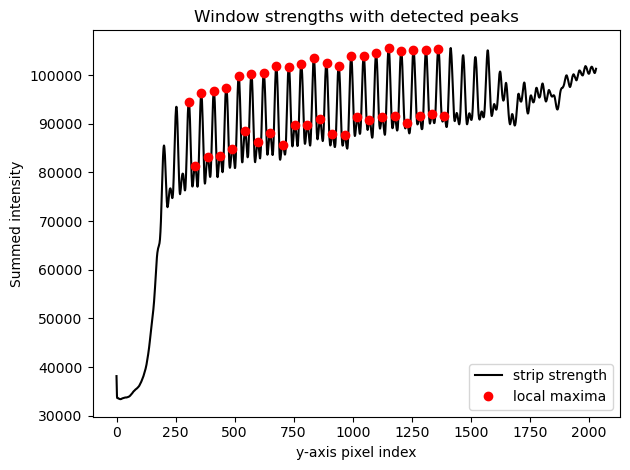

26


In [ ]:
import scipy.signal
import numpy as np

x

left_bound = 500 # TUNE THIS
right_bound = 1700 # TUNE THIS
start_pixel = 280 # TUNE THIS
end_pixel = 1400 # TUNE THIS
window_detect_height_nm = 0.2 # TUNE THIS
# window_height_nm = None

crop = util.crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel, 
                      window_detect_height_nm=window_detect_height_nm, window_height_nm=None)
peak_indices = crop.get_windows(get_plot=True)
print(crop.window_height)

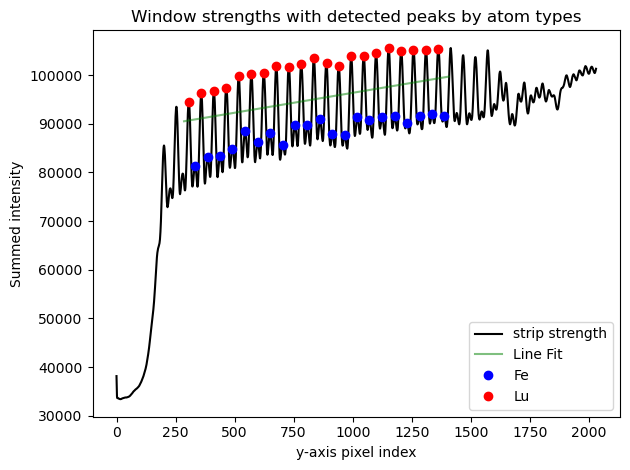

In [3]:
_ = crop.get_layers(num_clusters=2, get_plot=True)

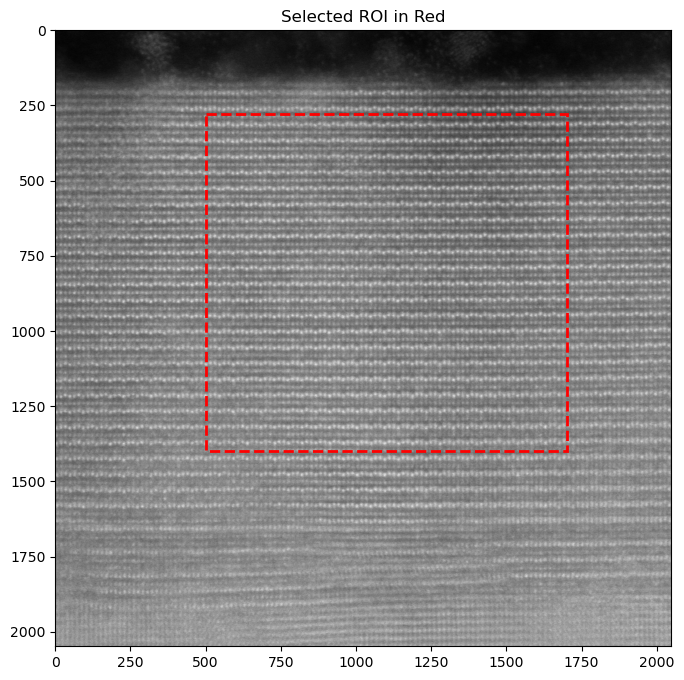

In [4]:
from matplotlib.patches import Rectangle

# Assume: left/right are x (columns), start/end are y (rows)
x0, x1 = left_bound, right_bound
y0, y1 = start_pixel, end_pixel
w, h = x1 - x0, y1 - y0

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(s.data, cmap="gray")  # HyperSpy signal data
ax.add_patch(Rectangle((x0, y0), w, h, fill=False, linewidth=2, edgecolor="red", linestyle="--", zorder = 10))
# ax.add_patch(Rectangle((x0, 0), w, s.data.shape[1], fill=True, alpha=0.2, 
#                        facecolor='blue', zorder = 9))
ax.set_xlim(0, s.data.shape[1])
ax.set_ylim(s.data.shape[0], 0)  # keep origin at top-left
# ax.set_title("Scanning Region in Blue and Selected ROI in Red")
ax.set_title("Selected ROI in Red")
plt.show()

To see whether the window heights, left and right boundaries we have chosen make sense, we test all of the windows by interating through the indices of windows and see the results in the cell below and adjust accordingly. If some windows are clearly not aligned (e.g. falling above or below the window), please feel free to crop them off from this test.

In [5]:
get_plot = False
if get_plot:
    windows_num = len(crop.layers)
    fig, ax = plt.subplots(windows_num, 1, figsize=(8, windows_num*0.8), sharex=True, sharey=True)
    for window_index in range(windows_num):
        layer = crop.layers[window_index]
        s_cropped = layer.image
        ax[window_index].imshow(s_cropped, interpolation='nearest', vmax=np.median(np.array(s_cropped))+3*np.std(np.array(s_cropped)))
        ax[window_index].set_title(f'Windows #{window_index}')

    plt.tight_layout()

## Atom Positions Finding & Refining Functions

In [6]:
for window_ind in range(len(crop.layers)):
    # crop.layers[window_ind].atom_finding(disk_param_nm = 0.235, obj_param_nm = 0.2, holes_param_nm = 0.2,
    #                     min_separation_nm = 0.095)
    crop.layers[window_ind].atom_finding_hs(separation = 8)

    # temporary fix, layer #29
    if window_ind == 29:
        crop.layers[window_ind].detected_atom_positions = np.delete(crop.layers[window_ind].detected_atom_positions, 10, axis=0)
        crop.layers[window_ind].atom_positions = np.delete(crop.layers[window_ind].atom_positions, 10, axis=0)
    crop.layers[window_ind].filling_blanks(sigma_allowance = 3)
    

After all, refine atom locations based on iterations towards fitting a Gaussian shape based on the atom radius.

In [7]:
%%capture
for window_ind in range(len(crop.layers)):
    crop.layers[window_ind].atom_refine(mask_radius_nm = 0.174*0.4, get_plot = False)

We can see what one window is like by peaking at one of it:

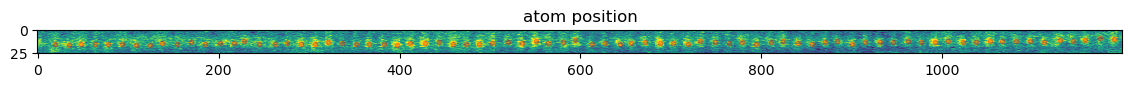

In [8]:
crop.layers[29].plot_layer()

## Intensity Fit & Outliers Analysis

In [9]:
crop.get_intensities(type = 'verticle_bar', width_type = 'nm', width = 0.174*0.9)
# crop.get_intensities(type = 'rectangle', width_type = 'nm', width = 0.174*0.9, height = 0.23)

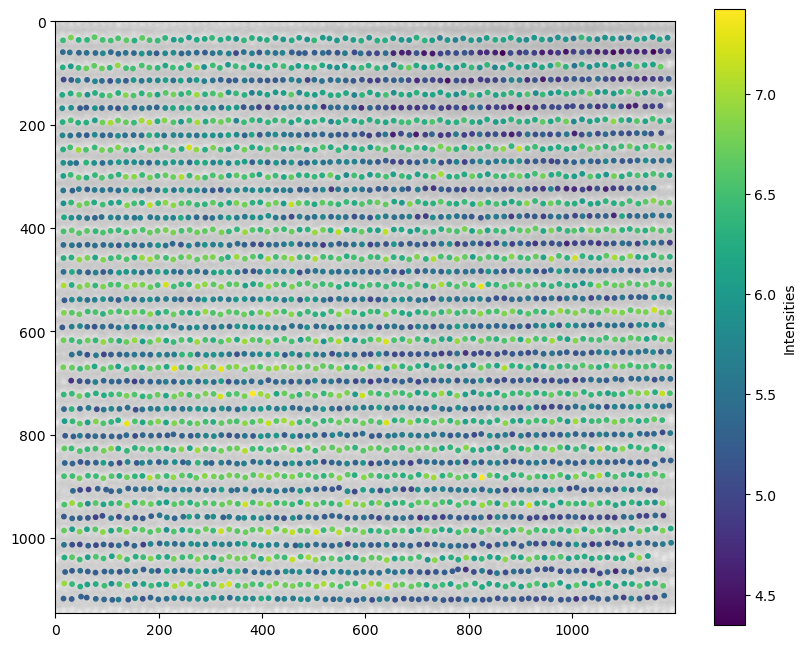

In [10]:
crop.plot_intensities(atom_type='all', type = 'max', start_ind=0, end_ind=42)

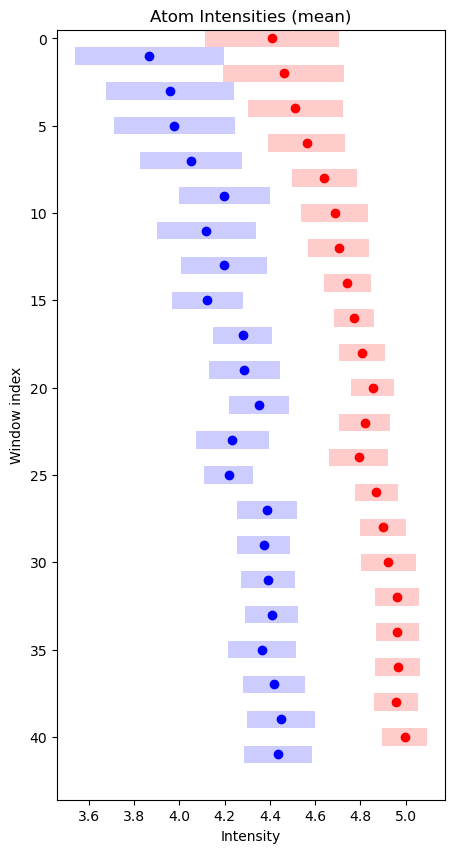

In [11]:
type = 'mean' # 'mean' or 'max'

plt.figure(figsize=(5, 10))
for window_ind in range(len(crop.layers)):
    if type == 'mean':
        mean = crop.layers[window_ind].mean_intensities
        std = crop.layers[window_ind].std_intensities
    elif type == 'max':
        mean = crop.layers[window_ind].mean_max_intensities
        std = crop.layers[window_ind].std_max_intensities
    
    if crop.layers[window_ind].atom_type == 'Fe':
        plt.bar(mean, height=1, bottom=window_ind-0.5 , width=2*std, color='b', alpha=0.2, label='Std. Dev. Range')
        plt.scatter(mean, window_ind, color='b')
    elif crop.layers[window_ind].atom_type == 'Lu':
        plt.bar(mean, height=1, bottom=window_ind-0.5 , width=2*std, color='r', alpha=0.2, label='Std. Dev. Range')
        plt.scatter(mean, window_ind, color='r')

plt.title(f'Atom Intensities ({type})')
plt.xlabel('Intensity')
plt.ylabel('Window index')

plt.gca().invert_yaxis()

plt.show()

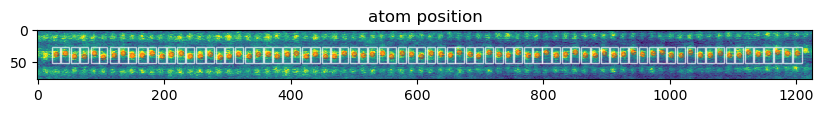

In [14]:
crop.layers[10].plot_integrate_areas()

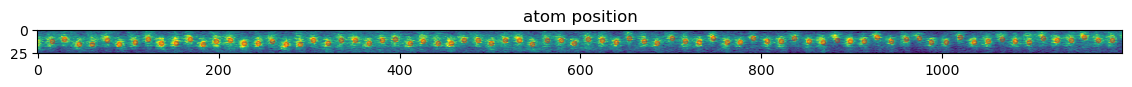

In [15]:
crop.layers[10].plot_layer()